Files already downloaded and verified
==>> gt: 9 <<===
==>> img   <<===


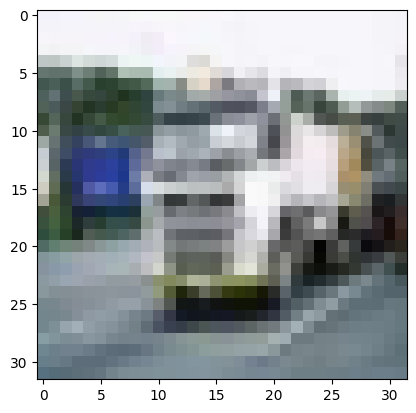

In [8]:

import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms as T
from matplotlib import pyplot as plt

# A
ds = CIFAR10(root ='data', train=True, download=True)


# B
item = ds[1000]
img, gt = item

print(f"==>> gt: {gt} <<===")
print(f"==>> img   <<===")
plt.imshow(img, cmap = "gray")

In [9]:
ts_tfs = T.Compose( [T.Resize((32, 32)),
                    #  T.Grayscale(num_output_channels = 3),
                     T.ToTensor(),
                     T.Normalize(mean =0.5, std = 0.5)] )

# Optimization for Second Try
ts_tfs = T.Compose([
    T.Resize((32, 32)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

ds = CIFAR10(root ='data', train=True, download=True,  transform = ts_tfs)
ts_ds = CIFAR10(root='data', train=False, download=True, transform=ts_tfs)

ts_ds[1000]

Files already downloaded and verified
Files already downloaded and verified


(tensor([[[-0.9686, -0.9686, -0.9686,  ..., -0.6314, -0.3961, -0.9686],
          [-0.4118, -0.6471, -0.6235,  ..., -0.2000, -0.2706, -0.9686],
          [-0.2392, -0.5059, -0.6627,  ..., -0.1137, -0.6706, -0.9686],
          ...,
          [-0.9686, -0.6863, -0.3882,  ..., -0.1843, -0.2000, -0.2078],
          [-0.9686, -0.7255, -0.5608,  ..., -0.1922, -0.1843, -0.2078],
          [-0.9686, -0.7176, -0.7098,  ..., -0.9686, -0.9686, -0.9686]],
 
         [[-0.9686, -0.9686, -0.9686,  ..., -0.6078, -0.4039, -0.9686],
          [-0.4824, -0.6784, -0.6706,  ..., -0.2235, -0.2941, -0.9686],
          [-0.3647, -0.5608, -0.7020,  ..., -0.1373, -0.7020, -0.9686],
          ...,
          [-0.9686, -0.7098, -0.4431,  ..., -0.2784, -0.2863, -0.3020],
          [-0.9686, -0.7725, -0.6078,  ..., -0.2706, -0.2627, -0.3020],
          [-0.9686, -0.7569, -0.7490,  ..., -0.9686, -0.9686, -0.9686]],
 
         [[-0.9686, -0.9686, -0.9686,  ..., -0.6471, -0.5059, -0.9686],
          [-0.6784, -0.7412,

In [10]:
from torch.utils.data import random_split, DataLoader
total_len = len(ds)
tr_len = int(total_len * 0.9)
vl_len = total_len - tr_len
print(f"==>> tr_len: {tr_len}")
print(f"==>> vl_len: {vl_len}")
tr_ds, vl_ds = random_split(dataset = ds, lengths = [tr_len, vl_len])
print("".center(50, "-"))
print(f"==>> tr_ds: {len(tr_ds)}")
print(f"==>> vl_ds: {len(vl_ds)}")


bs = 256
tr_dl = DataLoader(dataset=tr_ds, batch_size=bs, num_workers=4, shuffle=True)
vl_dl = DataLoader(dataset=vl_ds, batch_size=bs, num_workers=4, shuffle=False)
ts_dl = DataLoader(dataset=ts_ds, batch_size=bs, num_workers=4, shuffle=False)

==>> tr_len: 45000
==>> vl_len: 5000
--------------------------------------------------
==>> tr_ds: 45000
==>> vl_ds: 5000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:

loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 20

model.to(device)


CustomModel(
  (conv_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act): ReLU()
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear_1): Linear(in_features=256, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=10, bias=True)
)

In [24]:
from torch.optim.lr_scheduler import StepLR

# Create a scheduler object
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    model.train()
    print(f"==>> Starting Epoch: {epoch+1}")
    epoch_loss, epoch_acc = 0, 0

    for idx, batch in enumerate(tr_dl):
        # if idx == 1: break
        imgs, gts = batch
        imgs, gts = imgs.to(device), gts.to(device)

        pred_results = model(imgs)

        loss = loss_fn(pred_results, gts)
        predictions = torch.argmax(pred_results, dim=1)
        match = (predictions==gts).sum()

        epoch_loss += loss.item()
        epoch_acc += match.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Update the learning rate
    scheduler.step()

    print("".center(50, "-"))
    print(f"{epoch + 1}-epoch training loss       -> {(epoch_loss / len(tr_dl)):.3f}")
    print(f"{epoch + 1}-epoch training acc        -> {(epoch_acc / len(tr_dl.dataset)):.3f}")

    model.eval()

    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0

        for idx, batch in enumerate(vl_dl):
            # if idx == 1: break
            imgs, gts = batch
            imgs, gts = imgs.to(device), gts.to(device)
            pred_results = model(imgs)

            loss = loss_fn(pred_results, gts)
            predictions = torch.argmax(pred_results, dim=1)
            match = (predictions==gts).sum()

            val_epoch_loss += loss.item()
            val_epoch_acc  += match.item()
        print("".center(50, "-"))
        print(f"{epoch + 1}-epoch validation loss       -> {(val_epoch_loss / len(vl_dl)):.3f}")
        print(f"{epoch + 1}-epoch validation acc        -> {(val_epoch_acc / len(vl_dl.dataset)):.3f}")


==>> Starting Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


--------------------------------------------------
1-epoch training loss       -> 1.593
1-epoch training acc        -> 0.420
--------------------------------------------------
1-epoch validation loss       -> 1.580
1-epoch validation acc        -> 0.421
==>> Starting Epoch: 2
--------------------------------------------------
2-epoch training loss       -> 1.552
2-epoch training acc        -> 0.433
--------------------------------------------------
2-epoch validation loss       -> 1.546
2-epoch validation acc        -> 0.433
==>> Starting Epoch: 3
--------------------------------------------------
3-epoch training loss       -> 1.514
3-epoch training acc        -> 0.449
--------------------------------------------------
3-epoch validation loss       -> 1.496
3-epoch validation acc        -> 0.445
==>> Starting Epoch: 4
--------------------------------------------------
4-epoch training loss       -> 1.487
4-epoch training acc        -> 0.462
--------------------------------------------

In [25]:

# 1st Try
# 10-epoch training acc        -> 0.508
# --------------------------------------------------
# 10-epoch validation acc      -> 0.496

# 2nd Try - Changing Transformers
# 10-epoch training acc        -> 0.479
# --------------------------------------------------
# 10-epoch validation acc        -> 0.476

# 3nd Try - Changing Transformers
# 10-epoch training acc        -> 0.506
# --------------------------------------------------
# 10-epoch validation acc        -> 0.506

# 4th Try - Changing Transformers
# 100-epoch training acc        -> 0.646
# --------------------------------------------------
# 100-epoch validation acc        -> 0.619

In [26]:

rasmlar, javoblar = next(iter(ts_dl))
print(rasmlar.shape)
print(javoblar.shape)
hamma_bashoratlar, hamma_rasmlar, hamma_javoblar = [], [], []

torch.Size([256, 3, 32, 32])
torch.Size([256])


In [27]:



for idx, (rasm, javob) in enumerate(zip(rasmlar, javoblar)):
    rasm, javob = rasm.to(device), javob.to(device)
    rasm = rasm.unsqueeze(dim = 0)
    bashorat =  model(rasm)
    bashorat_javob = torch.argmax(bashorat, dim = 1).item()
    hamma_bashoratlar.append(bashorat_javob); hamma_rasmlar.append(rasm), hamma_javoblar.append(javob)

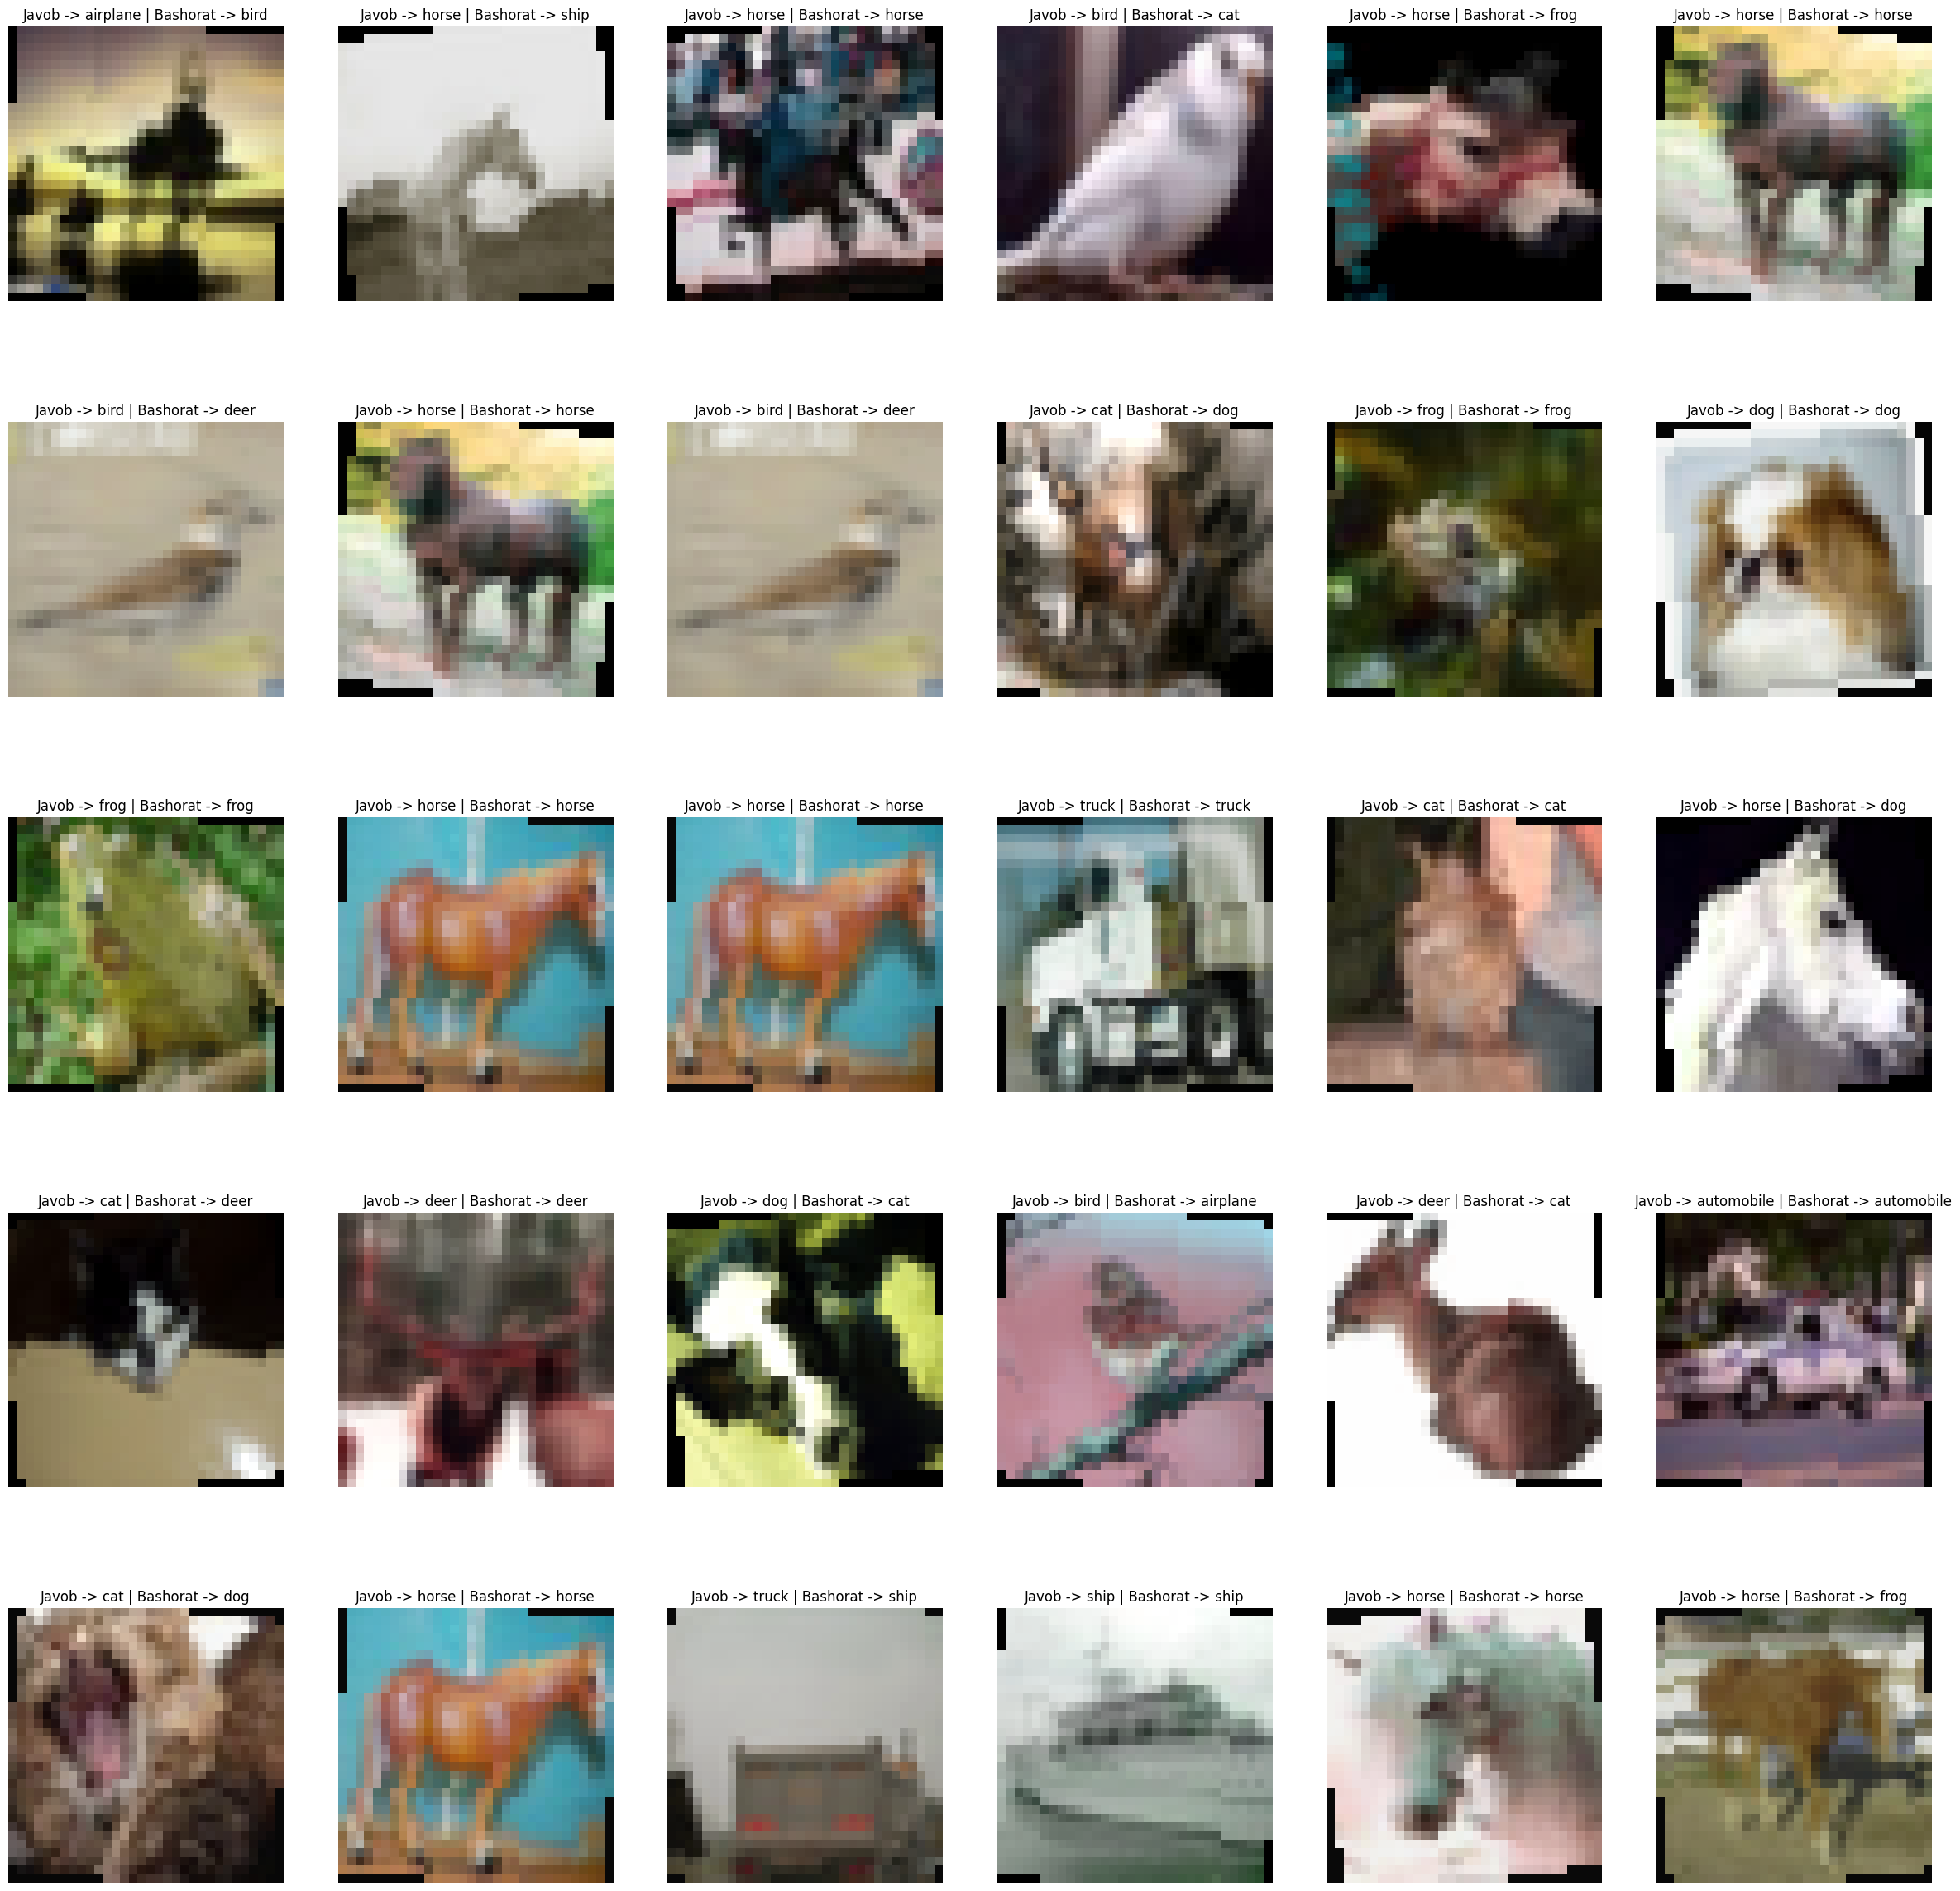

In [28]:

import random
from matplotlib import pyplot as plt
import numpy as np
rasmlar_soni, qatorlar_soni = 30, 5
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
# Assuming hamma_rasmlar contains tensors normalized with mean=0.5 and std=0.5

def denormalize(image_tensor):
    # Reverses the normalization operation
    mean = 0.5
    std = 0.5
    image_tensor = image_tensor * std + mean  # Apply the inverse of the normalization
    image_tensor = image_tensor.clamp(0, 1)  # Clamp values to the range [0, 1] to avoid overflow
    return image_tensor

plt.figure(figsize=(30, 30))
indekslar = [random.randint(a = 0, b = len(hamma_rasmlar) - 1) for _ in range(rasmlar_soni)]
for idx, indeks in enumerate(indekslar):
    rasm = hamma_rasmlar[indeks]  # Assuming this is a normalized tensor
    javob = hamma_javoblar[indeks]
    bashorat = hamma_bashoratlar[indeks]

    javob_name = class_names[javob]  # Assuming javob is an index
    bashorat_name = class_names[bashorat]  # Assuming bashorat is an index

    rasm = denormalize(rasm)  # Denormalize the image tensor

    plt.subplot(qatorlar_soni, rasmlar_soni // qatorlar_soni, idx + 1)
    plt.axis("off")
    plt.imshow(rasm.squeeze(0).cpu().permute(1, 2, 0).numpy())  # Convert tensor to numpy array
    plt.title(f"Javob -> {javob_name} | Bashorat -> {bashorat_name}")